              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.50      0.67         2

    accuracy                           0.95        21
   macro avg       0.97      0.75      0.82        21
weighted avg       0.95      0.95      0.95        21



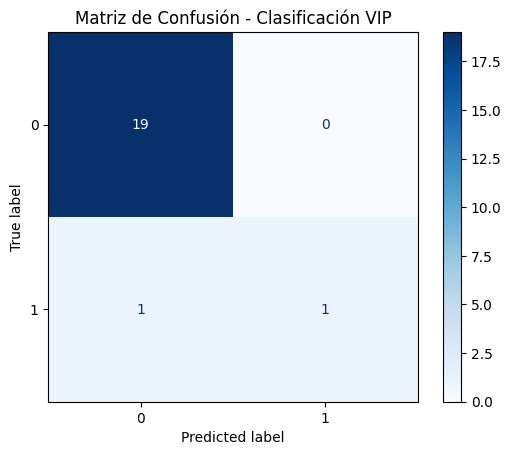

In [5]:
# =========================================
# 1️⃣ Librerías
# =========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# =========================================
# 2️⃣ Cargar datos reales
# =========================================
clientes = pd.read_excel("clientes.xlsx")
ventas = pd.read_excel("ventas.xlsx")
detalle = pd.read_excel("detalle_ventas.xlsx")

# Asegurar tipos numéricos
detalle["cantidad"] = pd.to_numeric(detalle["cantidad"], errors="coerce")
detalle["precio_unitario"] = pd.to_numeric(detalle["precio_unitario"], errors="coerce")
detalle["importe"] = pd.to_numeric(detalle["importe"], errors="coerce")

# Calcular importe si falta
detalle["importe"] = detalle["cantidad"] * detalle["precio_unitario"]

# =========================================
# 3️⃣ Unificar datasets
# =========================================
df = detalle.merge(ventas[["id_venta","id_cliente","medio_pago"]], on="id_venta", how="left")
df = df.merge(clientes[["id_cliente","nombre_cliente","ciudad"]], on="id_cliente", how="left")

# =========================================
# 4️⃣ Crear variable objetivo (VIP)
# =========================================
ventas_cliente = df.groupby("id_cliente", as_index=False).agg(
    ingreso_total=("importe","sum"),
    n_ventas=("id_venta","nunique"),
    unidades=("cantidad","sum"),
    ciudad=("ciudad","first"),
    medio_pago=("medio_pago","first")
)

# Definir umbral VIP: top 10% de ingreso_total
umbral_vip = ventas_cliente["ingreso_total"].quantile(0.90)
ventas_cliente["cliente_vip"] = (ventas_cliente["ingreso_total"] >= umbral_vip).astype(int)

# =========================================
# 5️⃣ Variables predictoras y target
# =========================================
X = ventas_cliente[["ingreso_total","n_ventas","unidades","ciudad","medio_pago"]]
y = ventas_cliente["cliente_vip"]

# Codificar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# =========================================
# 6️⃣ División Train/Test
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =========================================
# 7️⃣ Entrenamiento del Modelo
# =========================================
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# =========================================
# 8️⃣ Predicción
# =========================================
y_pred = modelo.predict(X_test)

# =========================================
# 9️⃣ Métricas
# =========================================
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Clasificación VIP")
plt.show()